# Estimation par noyau

In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from json_processing import *
from useful_fcts import latlon_to_xyz
from progressbar import ProgressBar, Percentage, Bar
import plotly.graph_objects as go
import json
import time
import plotly.io as pio
pio.renderers.default = 'notebook'

## Import des données

In [2]:
nb_total_points = 0
nb_files = 0
filenames = None
files_content = None

def load_data():
    global nb_total_points, nb_files, filenames, files_content
    filenames = get_files_from_folder("json", "../extracted_data/JSON/originals_mm_full_truncated/")
    files_content = open_json(filenames)
    nb_files = len(files_content)
    nb_total_points = sum([len(file) for file in files_content.values()])
load_data()

In [3]:
def bar_custom(total=nb_files):
    return ProgressBar(widgets=[Percentage(), Bar()], maxval=total).start()

## Ecraser les données

In [43]:
def convert_to_json_serializable(obj):
    if isinstance(obj, dict):
        # Si l'objet est un dictionnaire, parcourez ses éléments
        for key, value in obj.items():
            obj[key] = convert_to_json_serializable(value)  # Appel récursif pour chaque valeur
    elif isinstance(obj, list):
        # Si l'objet est une liste, parcourez ses éléments
        for i, item in enumerate(obj):
            obj[i] = convert_to_json_serializable(item)  # Appel récursif pour chaque élément de la liste
    elif isinstance(obj, np.int64):
        # Si l'objet est de type np.int64, convertissez-le en int
        obj = int(obj)
    return obj

In [44]:
i = 0
bar = bar_custom()

for filename, data in files_content.items():
    path = f"../extracted_data/JSON/originals_mm_full_truncated/{filename}.json"
    with open(path, 'w') as f:
        json.dump(data, f)
    i += 1
    bar.update(i)
bar.finish()

100%|#########################################################################|


# Calcul du virage brut

In [4]:
def calculate_raw_curve(data):
    azimuths = [p["azimuth"] for p in data.values()]
    # calcul de la courbure brute
    curves = np.diff(azimuths)
    for i in range(len(curves)):
        if curves[i] > 180:
            curves[i] -= 360
        elif curves[i] < -180:
            curves[i] += 360
    # Mise à jour des données
    for i in range(1, len(data)):
        data[f"point{i}"]["curve"] = curves[i-1]
    data["point0"]["curve"] = curves[0]

In [5]:
k = 0
bar = bar_custom()
nb_modified_outlying_slopes = 0

for filename, data in files_content.items():
    calculate_raw_curve(data)
    k+=1
    bar.update(k)

bar.finish()

100%|#########################################################################|


# Sélection du dataset

In [6]:
print(f"Nombre de traces totales : {nb_files}")
print(f"Nombre de points totaux : {nb_total_points}")

Nombre de traces totales : 608
Nombre de points totaux : 220193


In [101]:
def get_tracks_data(size, dbt=0):
    tracks = [track for track in list(files_content.values())[dbt:dbt+size]]
    speeds = np.array([3.6 * p["speed"] for track in tracks for p in track.values()])
    slope_values = np.array([p["slope"] for track in tracks for p in track.values()])
    curve_values = np.array([p["curve"] for track in tracks for p in track.values()])
    return speeds, slope_values, curve_values

# Analyse des données

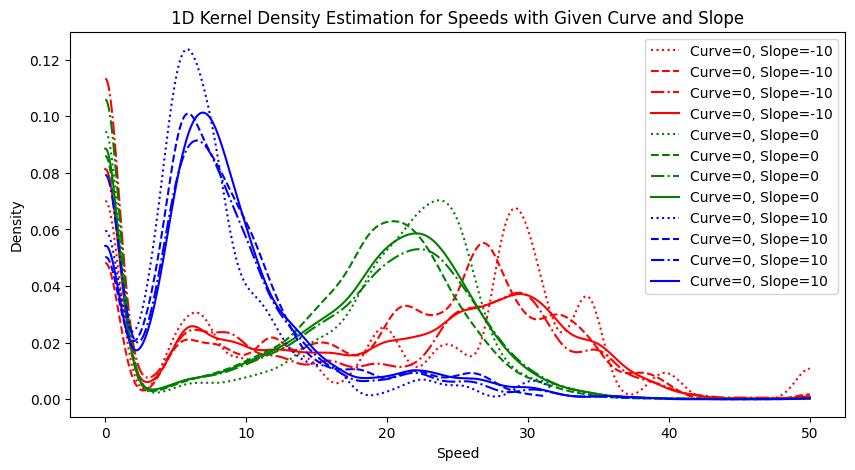

In [85]:
colors = ["red", "green", "blue"]
styles = [":", "--", "-.", "-"]
tracks = [50, 100, 300, 600]

def get_data(slope, curve, tracks):
        speeds, slope_values, curve_values = get_tracks_data(tracks)
        selected_data = np.array([speeds[:], slope_values[:], curve_values[:]])
        
        mask = ((np.abs(selected_data[1, :]-slope) < 1) &
                (np.abs(selected_data[2, :]-curve) < 5))

        selected_data = selected_data[:, mask]

        # Reshape the data to fit the input requirements of KernelDensity
        selected_data = selected_data[0,:].reshape(-1, 1)

        # Fit kernel density estimator
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(selected_data)

        # Create a range of speed values for prediction
        speed_range = np.linspace(min(selected_data), max(selected_data), 1000).reshape(-1, 1)

        # Get log-densities for the speed range
        log_densities = kde.score_samples(speed_range)
        densities = np.exp(log_densities)
        return speed_range, densities

fig = plt.figure(figsize=(10, 5))   
plt.title('1D Kernel Density Estimation for Speeds with Given Curve and Slope')

for i in range(3):
        for j in range(4):
                f = lambda x: 10*(-1 +i)
                speed_range, densities = get_data(f(i), 0, tracks[j])
                plt.plot(speed_range, densities, label=f'Curve={0}, Slope={f(i)}', color=colors[i], linestyle=styles[j])

plt.xlabel('Speed')
plt.ylabel('Density')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


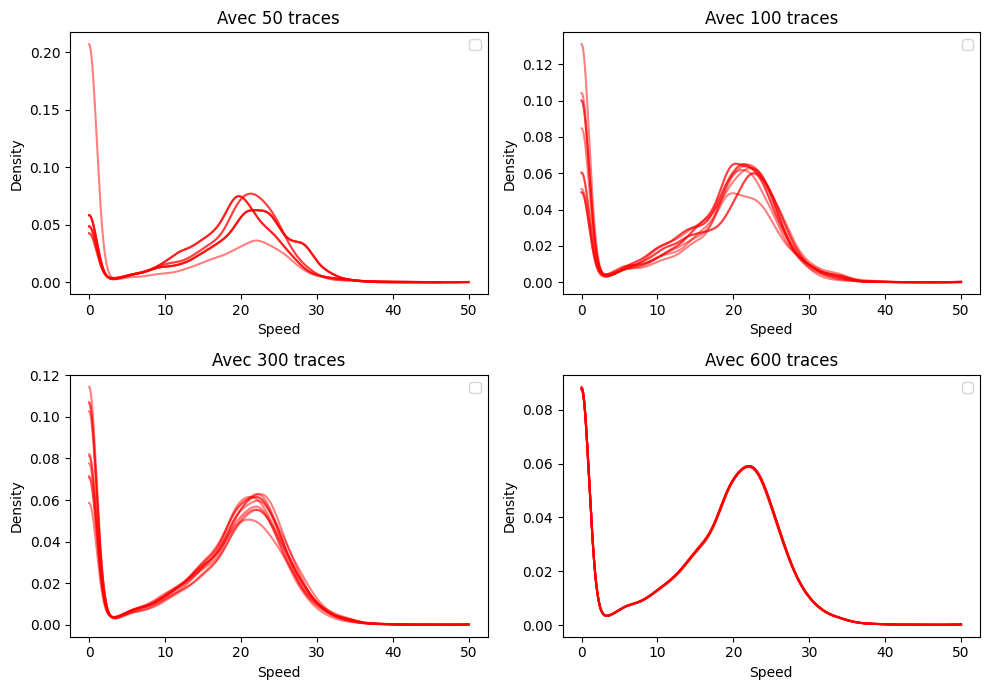

In [93]:
nb_tracks = [[50, 100],
             [300, 600]]

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i in range(2):
    for j in range(2):
        for _ in range(10):
            speed_range, densities = get_data(0, 0, nb_tracks[i][j])
            ax[i][j].plot(speed_range, densities, color="red", alpha=0.5)
        ax[i][j].set_title(f"Avec {nb_tracks[i][j]} traces")
        ax[i][j].set_xlabel('Speed')
        ax[i][j].set_ylabel('Density')
        ax[i][j].legend()

# optimize space between graphs
plt.tight_layout()

plt.show()

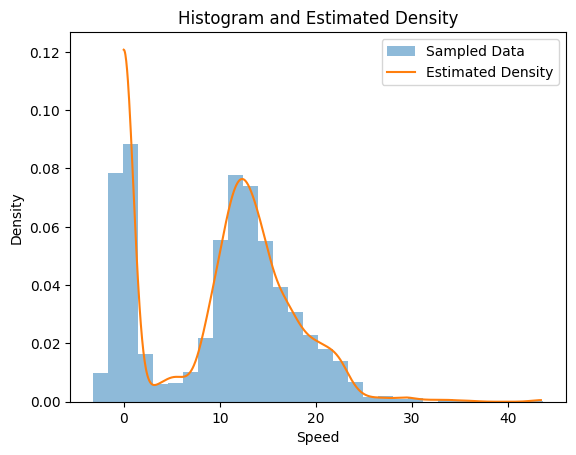

In [41]:


# Sample from the estimated densities
sampled_data = kde.sample(n_samples=5000)

# Plot the histogram of the sampled data
plt.hist(sampled_data, bins=30, density=True, alpha=0.5, label='Sampled Data')

# Plot the estimated kernel density
plt.plot(speed_range, densities, label='Estimated Density')

plt.title('Histogram and Estimated Density')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.legend()
plt.show()


In [102]:
# Récupération des données
speeds, slope_values, curve_values = get_tracks_data(300)

# Create a grid of values for prediction
s_min, s_max, s_scale = 0, 50, 0.5
slope_min, slope_max, slope_scale = -25, 25, 1
curve_min, curve_max, curve_scale = -180, 180, 20

speed_grid, slope_grid, curve_grid =    np.linspace(s_min, s_max, int((s_max - s_min) / s_scale) + 1, dtype=np.int16), \
                                        np.linspace(slope_min, slope_max, int((slope_max - slope_min) / slope_scale) + 1, dtype=np.int16), \
                                        np.linspace(curve_min, curve_max, int((curve_max - curve_min) / curve_scale) + 1, dtype=np.int16)

# Récupérer la densité correspondante
def get_data(slope, curve):
        selected_data = np.array([speeds[:], slope_values[:], curve_values[:]])
        
        mask = ((np.abs(selected_data[1, :]-slope) <= slope_scale/2) &
                (np.abs(selected_data[2, :]-curve) <= curve_scale/2))

        selected_data = selected_data[:, mask]

        if len(selected_data[0]) == 0:
            return None
        
        # Reshape the data to fit the input requirements of KernelDensity
        selected_data = selected_data[0,:].reshape(-1, 1)

        # Fit kernel density estimator
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(selected_data)

        # Get log-densities for the speed range
        log_densities = kde.score_samples(speed_grid.reshape(-1, 1))
        densities = np.exp(log_densities)
        return kde

data = {}

for slope in slope_grid:
        for curve in curve_grid:
                data[f"{slope}_{curve}"] = get_data(slope, curve)

In [122]:
mean_default_gaussian = 8
std_default_gaussian = 6

def get_speed(slope, curve):
    # Si la valeur excède ce qui est connu
    if slope < slope_min or slope > slope_max or curve < curve_min or curve > curve_max:
        return min(s_max, max(s_min, np.random.normal(mean_default_gaussian, std_default_gaussian)))
    
    est_slope = int(int((slope - slope_min) / slope_scale) * slope_scale + slope_min)
    est_curve = int(int((curve - curve_min) / curve_scale) * curve_scale + curve_min)

    if f"{est_slope}_{est_curve}" in data.keys() and data[f"{est_slope}_{est_curve}"] is not None:
        return data[f"{est_slope}_{est_curve}"].sample(n_samples=1)[0][0]

    return min(s_max, max(s_min, np.random.normal(mean_default_gaussian, std_default_gaussian)))

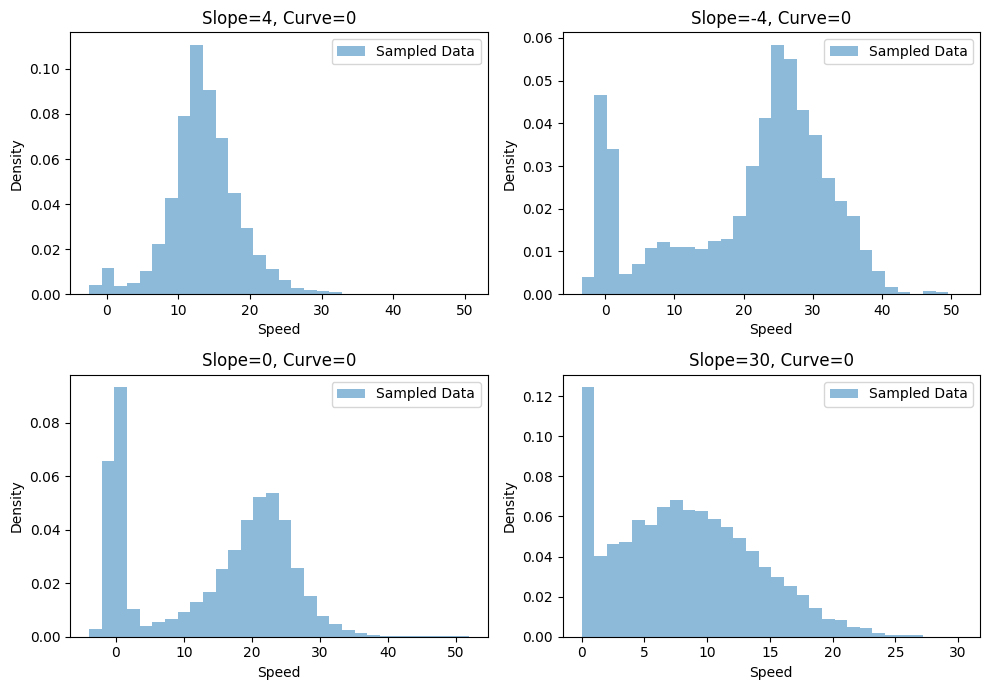

In [106]:
test = []
x_values = [(4, 0), (-4, 0), (0, 0), (30, 0)]

for slope, curve in x_values:
    values = []
    for _ in range(10000):
        values.append(get_speed(slope, curve))
    test.append(values)

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i in range(2):
    for j in range(2):
        ax[i][j].hist(test[2*i+j], bins=30, density=True, alpha=0.5, label='Sampled Data')
        ax[i][j].set_title(f"Slope={x_values[2*i+j][0]}, Curve={x_values[2*i+j][1]}")
        ax[i][j].set_xlabel('Speed')
        ax[i][j].set_ylabel('Density')
        ax[i][j].legend()

# optimize space between graphs
plt.tight_layout()

plt.show()

# Test sur les données

In [123]:
# Récupérer 100 traces qui ne sont pas dans le dataset
tracks_evaluation = [track for track in list(files_content.values())[400:450]]

In [124]:
def calculate_time(track):
    real_time = (datetime.fromisoformat(track[f"point{len(track)-1}"]["time"]) - datetime.fromisoformat(track[f"point0"]["time"])).total_seconds()
    time = 0
    for i in range(1, len(track)):
        d_parcourue = track[f"point{i}"]["d_parcourue"] - track[f"point{i-1}"]["d_parcourue"]
        speed = track[f"point{i}"]["speed"]
        if speed < 1e-1:
            time += 1
            continue
        time += d_parcourue / speed
    return time, real_time

In [125]:
calculate_time(tracks_evaluation[1])

(225.06691341454905, 231.23)

In [126]:
def estimate_time(track, n=500):
    times = []
    for _ in range(n):
        time = 0
        for i in range(1, len(track)):
            d_parcourue = track[f"point{i}"]["d_parcourue"] - track[f"point{i-1}"]["d_parcourue"]
            speed = get_speed(track[f"point{i}"]["slope"], track[f"point{i}"]["curve"])
            if speed < 1e-1:
                time += 1
                continue
            time += d_parcourue / speed
        times.append(time)
    return np.median(times)

In [128]:
estimate_time(tracks_evaluation[0])

867.3511672980069

In [129]:
real_times = []
calculated_times = []
estimated_times = []

bar = bar_custom(len(tracks_evaluation))
i = 0

for track in tracks_evaluation:
    real_time, calculated_time = calculate_time(track)
    real_times.append(real_time)
    calculated_times.append(calculated_time)
    estimated_times.append(estimate_time(track))
    i += 1
    bar.update(i)

bar.finish()

100%|#########################################################################|


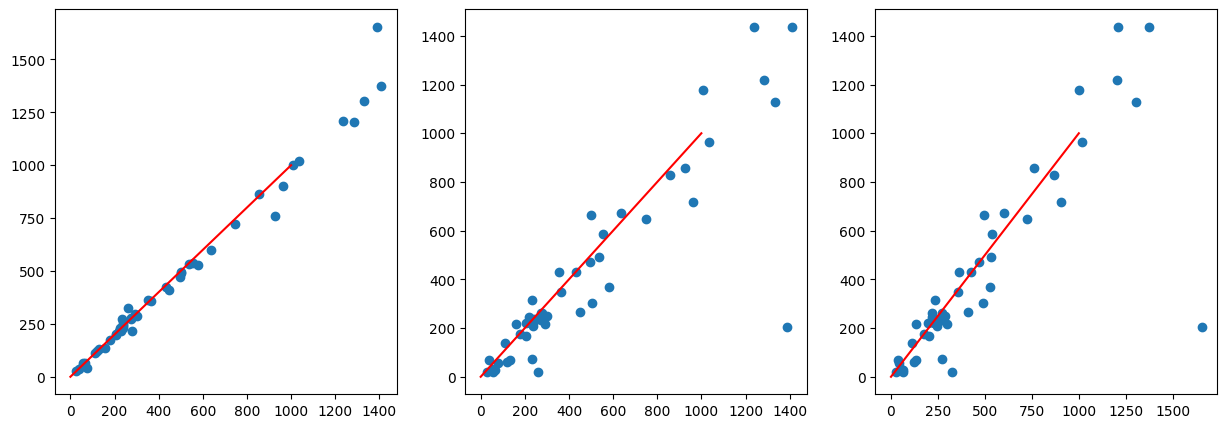

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(real_times, calculated_times, label='Calculated Time')
ax[0].plot([0, 1000], [0, 1000], color='red')
ax[1].scatter(real_times, estimated_times, label='estimated Time')
ax[1].plot([0, 1000], [0, 1000], color='red')
ax[2].scatter(calculated_times, estimated_times, label='estimates vs calculates Time')
ax[2].plot([0, 1000], [0, 1000], color='red')

plt.show()

(array([0.35222   , 0.35222   , 0.        , 0.        , 0.70443999,
        0.        , 0.35222   , 0.35222   , 0.70443999, 1.05665999,
        0.        , 1.05665999, 0.35222   , 1.76109998, 1.05665999,
        3.87441996, 1.40887999, 1.05665999, 0.35222   , 0.70443999,
        0.70443999, 0.        , 1.05665999, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.35222   ]),
 array([-0.92304546, -0.86626277, -0.80948008, -0.75269738, -0.69591469,
        -0.639132  , -0.5823493 , -0.52556661, -0.46878392, -0.41200122,
        -0.35521853, -0.29843584, -0.24165314, -0.18487045, -0.12808776,
        -0.07130506, -0.01452237,  0.04226032,  0.09904302,  0.15582571,
         0.2126084 ,  0.2693911 ,  0.32617379,  0.38295648,  0.43973918,
         0.49652187,  0.55330456,  0.61008726,  0.66686995,  0.72365264,
         0.78043533]),
 <BarContainer object of 30 artists>)

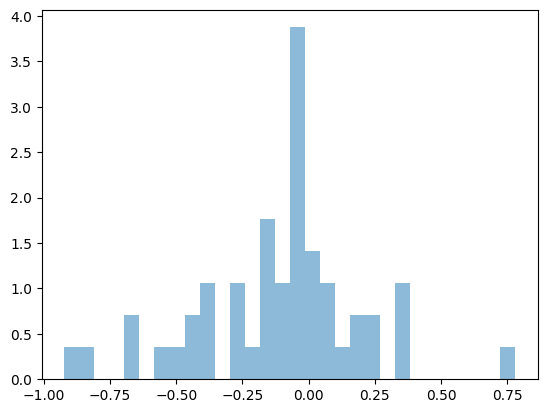

In [137]:
ecarts = [(estimated_times[i] - real_times[i])/real_times[i] for i in range(len(real_times))]
plt.hist(ecarts, bins=30, density=True, alpha=0.5, label='Sampled Data')